In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cooltools
import cooler

## Load in microcompartment loop anchors

In [10]:
# Load in the locations of all unique microcompartment anchors in BED format with chromosome, start (anchor coordinate minus 1 kb) and end (anchor coordinate plus 1 kb) columns
anchors = pd.read_csv(r'FILE_PATH_TO_ANCHOR_LIST.bed', sep='\t', header=None, names=['chr','start','end'])
anchors

,chr,start,end
0,chr5,31273000,31275000
1,chr5,31295500,31297500
2,chr5,31306700,31308700
3,chr5,31310500,31312500
4,chr5,31336200,31338200
...,...,...,...
127,chr8,85785750,85787750
128,chr8,85797300,85799300
129,chr8,85802000,85804000
130,chr8,85806500,85808500


In [11]:
# Calculate the anchor coordinate by averaging the start & end coordinates, and create a DataFrame containing just the chromosome and anchor coordinate
anchors['midpoint'] = (anchors['end'] + anchors['start']) // 2
anchorList = anchors[['chr','midpoint']]

# Subset the DataFrame of anchors to separate out the microcompartment anchors in Klf1 (on chr8) and in Ppm1g (on chr5)
anchorDataframeKlf1 = anchorList[anchorList['chr'] == 'chr8']
anchorDataframePpm1g = anchorList[anchorList['chr'] == 'chr5']

# Convert the region-separated anchor lists from DataFrames to lists for ease of downstream use
anchorListKlf1 = anchorDataframeKlf1['midpoint'].tolist()
anchorListPpm1g = anchorDataframePpm1g['midpoint'].tolist()

## Calculate rowsums and plot their distribution
### Whole-region balancing calculations

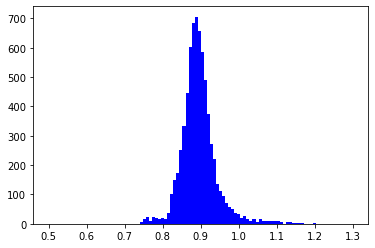

In [47]:
# Usage: Plot different datasets & regions by updating the filename and "region = regionsRCMC[x]" attributes, respectively 

saveDir = f'DIRECTORY_PATH'
fileName = f'FILE_NAME.svg' # swap out .svg for the desired output file format

# Specify the data resolution at which balanced rowsums will be calculated
resolution = 250

# Load in the desired dataset
clr_Data = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/'+str(resolution))

# List the Capture regions for region-by-region calculations
## For an apples-to-apples comparison, balanced rowsums are calculated at the RCMC regions for both the RCMC dataset as well as the genome-wide Micro-C (Hsieh 2020) and Hi-C (Bonev 2017) datasets
regionsRCMC = ['chr3:33804149-35704149','chr5:31257344-32382344','chr6:122451959-122876959','chr8:84846629-85856629','chr18:58032072-59034072']

# Specify which specific region you would like to calculate rowsums for
region = regionsRCMC[3]

# Load in the balanced contact matrix for the specified region
regionMat = clr_Data.matrix(balance=True).fetch(region)

# Create arrays of zeroes corresponding to the lengths (rows & columns) of the loaded in contact matrices
## The code here calculates both the rowsums and columnsums; they should be the same distribution, so you only need 1 of the 2
rowSum = np.zeros(len(regionMat))
columnSum = np.zeros(len(regionMat[0]))


# Iterate through the matrix bin-by-bin, summing up the balanced contact bin values for each row & column
## Only need to iterate through one half of the contact matrix (i.e., the half above the diagonal or the half below it) to capture it all due to reflected symmetry
i = 0
while i < len(regionMat):
    j = i # Ensures that we keep our iteration to one side of the diagonal instead of spanning the whole matrix 
    while j < len(regionMat[0]):
        val = regionMat[i][j] # Extracts the balanced value of the contact bin
        if np.isnan(val):
            val = 0 # NaN values can cause calculation errors, so this sets them to 0
        rowSum[i] += val # Adds the balanced value to the corresponding rowsum
        columnSum[j] += val # Adds the balanced value to the corresponding columnsum
        
        if j != i: # If j = i, then we're on the diagonal and there's no need to add in the reflected twin of the contact bin
            rowSum[j] += val # Adds the balanced value of the reflected twin to the corresponding rowsum
            columnSum[i] += val # Adds the balanced value of the reflected twin to the corresponding columnsum
        j += 1
    i += 1

# Plotting the rowsums and columnsums yields the same distribution, so this just runs ahead with the rowsums
## This filters out the rowsums that are 0 (i.e., those that correspond to empty stripes, either due to probe coverage or hard-to-map sites)
rowSumFilt = []
for i in rowSum:
    if i > 0:
        rowSumFilt.append(i)


# Plot a histogram of the rowsums
## Change the number of histogram bins as desired (100 used here)
## Change the range of visualization to capture and visually center the entire distribution
plt.hist(rowSumFilt,100,range=[3.75,8.25],align='mid',color='blue') # Klf1
# plt.hist(rowSumFilt,100,range=[1.1,3.4],align='mid',color='blue') # Ppm1g
# plt.hist(rowSumFilt,100,range=[0.3,1.0],align='mid',color='blue') # Fbn2
# plt.hist(rowSumFilt,100,range=[0.5,1.3],align='mid',color='blue') # Sox2

# plt.savefig(saveDir + fileName, dpi=1200)

### Microcompartment-containing bins balancing calculations

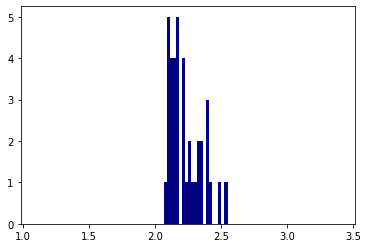

In [37]:
# Same approach as above, though now limited to only those contact bins containing microcompartment anchors
# Usage: Plot different datasets & regions by updating the filename, "region = regionsRCMC[x]", and "anchorReg = x" attributes 

saveDir = f'DIRECTORY_PATH'
fileName = f'FILE_NAME.svg' # swap out .svg for the desired output file format

# Specify the data resolution at which balanced rowsums will be calculated
resolution = 250

# Load in the desired dataset
clr_Data = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/'+str(resolution))

# List the Capture regions for region-by-region calculations
## For an apples-to-apples comparison, balanced rowsums are calculated at the RCMC regions for both the RCMC dataset as well as the genome-wide Micro-C (Hsieh 2020) and Hi-C (Bonev 2017) datasets
regionsRCMC = ['chr3:33804149-35704149','chr5:31257344-32382344','chr6:122451959-122876959','chr8:84846629-85856629','chr18:58032072-59034072']

# Specify which specific region you would like to calculate rowsums for
region = regionsRCMC[1]

# Load in the balanced contact matrix for the specified region
regionMat = clr_Data.matrix(balance=True).fetch(region)

# Specify the region of interest (either Klf1 or Ppm1g) for which to load in microcompartment anchors
anchorReg = 'Ppm1g'
if anchorReg == 'Klf1':
    anchors = anchorListKlf1
    offset = 84846629 # This offset is the start coordinate of the Klf1 region, allowing genomic coordinate conversion to bins
if anchorReg == 'Ppm1g':
    anchors = anchorListPpm1g
    offset = 31257344 # This offset is the start coordinate of the Ppm1g region, allowing genomic coordinate conversion to bins

# Create a list of bins which contain microcompartment anchors
bins = []
for i in anchors:
    bins.append((i - offset) // resolution)

# Create arrays of zeroes corresponding to the lengths (rows & columns) of the loaded in contact matrices
## The code here calculates both the rowsums and columnsums; they should be the same distribution, so you only need 1 of the 2
rowSum = np.zeros(len(regionMat))
columnSum = np.zeros(len(regionMat[0]))


# Iterate through the matrix bin-by-bin, summing up the balanced contact bin values for each row & column that contains a microcompartment anchor
## Only need to iterate through one half of the contact matrix (i.e., the half above the diagonal or the half below it) to capture it all due to reflected symmetry
i = 0
while i < len(regionMat):
    j = i # Ensures that we keep our iteration to one side of the diagonal instead of spanning the whole matrix 
    while j < len(regionMat[0]):
        if((i in bins) or (j in bins)): # The only difference from the calculation for the whole-region calculation, this if statement ensures that rowsums and columnsumes are only calculated for bins containing a microcompartment anchor            
            val = regionMat[i][j] # Extracts the balanced value of the contact bin
            if np.isnan(val):
                val = 0 # NaN values can cause calculation errors, so this sets them to 0
            rowSum[i] += val # Adds the balanced value to the corresponding rowsum
            columnSum[j] += val # Adds the balanced value to the corresponding columnsum

            if j != i: # If j = i, then we're on the diagonal & there's no need to add in the reflected twin of the contact bin
                rowSum[j] += val # Adds the balanced value of the reflected twin to the corresponding rowsum
                columnSum[i] += val # Adds the balanced value of the reflected twin to the corresponding columnsum
        j += 1
    i += 1


# Plotting the rowsums and columnsums yields the same distribution, so this just runs ahead with the rowsums
## This selects for bins containing microcompartment anchors and filters out the rowsums that are 0
## Note: Filtering for non-zero bins likely changes nothing since microcompartment anchor-containing bins are guaranteed not empty. Keeping it nonetheless for homogeneity with the whole-region calculation.
rowSumFilt = []
for x in bins:
    microcompRowSum = rowSum[x] # Extract the rowsum value of a microcompartment anchor-containing bin
    if microcompRowSum > 0:
        rowSumFilt.append(microcompRowSum) # Add the rowsum to the list of microcompartment rowsums if its greater than 0
    rowSumFilt.append()

    
# Plot a histogram of the rowsums
## Change the number of histogram bins as desired (100 used here)
## Change the range of visualization to capture and visually center the entire distribution
# plt.hist(rowSumFilt,100,range=[3.75,8.25],align='mid',color='navy') # Klf1
plt.hist(rowSumFilt,100,range=[1.1,3.4],align='mid',color='navy') # Ppm1g

# plt.savefig(saveDir + fileName, dpi=1200)